# Census Income Data Set

## 1.0 Preparing the ground

### 1.1 Imports

In [1]:
import shap
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
from boruta import BorutaPy
from tabulate import tabulate
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder


from sklearn.metrics import roc_curve
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix,classification_report

### 1.2 Functions

In [2]:
#Function to compute correlations between categorical features
def cramers_V(var1, var2):
    #https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
    crosstab =np.array(pd.crosstab(var1, var2, rownames=None, colnames=None)) # Cross table building
    stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
    obs = np.sum(crosstab) # Number of observations
    mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
    
    return (stat/(obs*mini))

In [3]:
#Function to simplify shap values plot
def plot_simplified_shap(df_shap, df): 
    
    #adapted from: https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d
    shap_v = pd.DataFrame(df_shap)
    feature_list = df.columns
    shap_v.columns = feature_list
    df_v = df.copy().reset_index().drop('index',axis=1)
    
    # Determine the correlation in order to plot with different colors
    corr_list = list()
    for i in feature_list:
        b = np.corrcoef(shap_v[i],df_v[i])[1][0]
        corr_list.append(b)
    corr_df = pd.concat([pd.Series(feature_list),pd.Series(corr_list)],axis=1).fillna(0)
    
    # Make a data frame. Column 1 is the feature, and Column 2 is the correlation coefficient
    corr_df.columns  = ['Variable','Corr']
    corr_df['Sign'] = np.where(corr_df['Corr']>0,'red','blue')
    
    shap_abs = np.abs(shap_v)
    k=pd.DataFrame(shap_abs.mean()).reset_index()
    k.columns = ['Variable','SHAP_abs']
    k2 = k.merge(corr_df,left_on = 'Variable',right_on='Variable',how='inner')
    k2 = k2.sort_values(by='SHAP_abs',ascending = False)
    
    return k2

### 1.3 Load the dataset

In [4]:
df_train_raw = pd.read_csv('data\\adult.data', header=None, skipinitialspace=True, na_values='?')
df_test_raw = pd.read_csv('data\\adult.test', skiprows=1, header=None, skipinitialspace=True, na_values='?')

### 1.4 Rename columns

In [5]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
        'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'class']

df_train_raw.columns = cols
df_test_raw.columns = cols

## 2.0 Data Description

In [6]:
df_train = df_train_raw.copy()
df_test= df_test_raw.copy()

### 2.1 Data Dimensions

In [7]:
print("Train\n# of rows: {}\n# of columns: {}\n".format(*df_train.shape))
print("Test\n# of rows: {}\n# of columns: {}".format(*df_test.shape))

Train
# of rows: 32561
# of columns: 15

Test
# of rows: 16281
# of columns: 15


We can deal with this amount of data in memory.

### 2.2 Class Distribution

In [8]:
df_train['class'].value_counts()

<=50K    24720
>50K      7841
Name: class, dtype: int64

Classes are unbalanced, therefore we need to choose a proper metric and/or balance the dataset.

### 2.3 Feature Description

In [9]:
tab = [
       ['Feature', 'Type', 'Description'],
       ['age', 'discrete', 'the age of the person.'],
       ['fnlwgt', 'discrete', 'people with similar demographic characteristics (within state) should have similar weights'],
       ['education_num', 'discrete', 'the highest level of education of the person.'],
       ['capital_gain', 'continuous', 'capital gain of an individual.'],
       ['capital_loss', 'continuous', 'capital loss of an individual.'],
       ['hours_per_week', 'discrete', 'the total of hours the person work in a week.'],
       ['workclass', 'nominal', 'employment status.'],
       ['education', 'ordinal', 'the highest level of education.'],
       ['marital_status', 'nominal', 'the highest level of education.'],
       ['occupation', 'nominal', 'type of occupation.'],
       ['relationship', 'nominal', 'relationship status.'],
       ['race', 'nominal', 'the race of the person.'],
       ['sex', 'nominal', 'the sex of the person.'],
       ['native_country', 'nominal', 'the native country of the person.'],
       ['class', 'nominal', 'marks if the person has an income greater than or equal to 50k.']
      ]

print(tabulate(tab, headers='firstrow'))

Feature         Type        Description
--------------  ----------  ------------------------------------------------------------------------------------------
age             discrete    the age of the person.
fnlwgt          discrete    people with similar demographic characteristics (within state) should have similar weights
education_num   discrete    the highest level of education of the person.
capital_gain    continuous  capital gain of an individual.
capital_loss    continuous  capital loss of an individual.
hours_per_week  discrete    the total of hours the person work in a week.
workclass       nominal     employment status.
education       ordinal     the highest level of education.
marital_status  nominal     the highest level of education.
occupation      nominal     type of occupation.
relationship    nominal     relationship status.
race            nominal     the race of the person.
sex             nominal     the sex of the person.
native_country  nominal     the native

### 2.4 Data Types

In [10]:
pd.concat([pd.DataFrame(df_train.dtypes, columns=['df train dtype']).T,pd.DataFrame(df_test.dtypes, columns=['df test dtype']).T]).T

,df train dtype,df test dtype
age,int64,int64
workclass,object,object
fnlwgt,int64,int64
education,object,object
education_num,int64,int64
marital_status,object,object
occupation,object,object
relationship,object,object
race,object,object
sex,object,object


* capital_gain and capital_loss should be float64.
* if we are taking minutes, seconds and/or miliseconds into account, hours_per_week should be float64.

## 3.0 Data Cleaning

### 3.1 Check NANs

In [11]:
pd.concat([pd.DataFrame(df_train.isna().sum(), columns=['# NaN values (df train)']).T,pd.DataFrame(df_test.isna().sum(), columns=['# NaN values (df test)']).T]).T

,# NaN values (df train),# NaN values (df test)
age,0,0
workclass,1836,963
fnlwgt,0,0
education,0,0
education_num,0,0
marital_status,0,0
occupation,1843,966
relationship,0,0
race,0,0
sex,0,0


* Conceptually, workclass and occupation are related to each other, therefore they may have a large amount of missing values together.

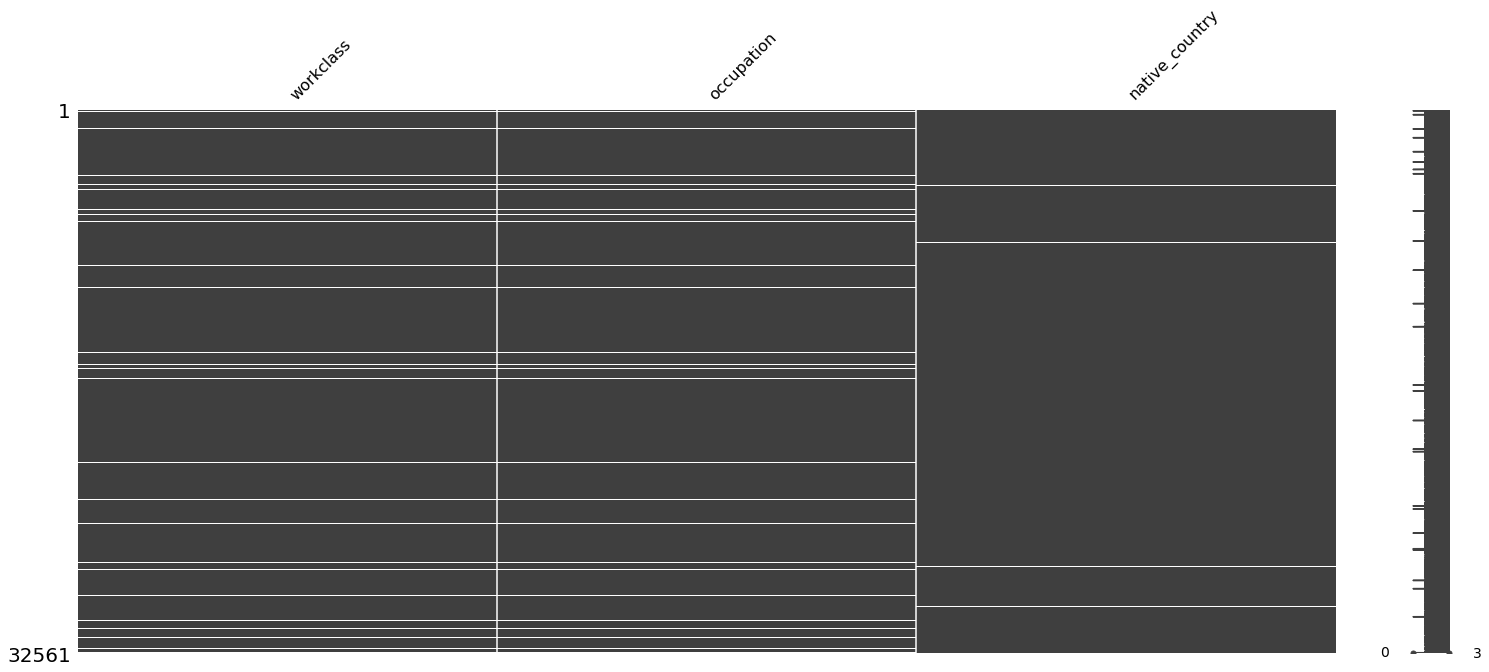

In [12]:
msno.matrix(df_train[['workclass', 'occupation', 'native_country']]);

In [13]:
max_occur_train_wc = max(df_train[df_train['workclass'].isnull()].shape[0], df_train[df_train['occupation'].isnull()].shape[0])
total_occur_wc = df_train[df_train['workclass'].isnull() & df_train['occupation'].isnull()].shape[0]
perc_occur_wc = total_occur_wc/max_occur_train_wc * 100

print('{} ({:.2f}%) of missing values in workclass and occupation occur together.'.format(total_occur_wc, perc_occur_wc))

1836 (99.62%) of missing values in workclass and occupation occur together.


In [14]:
max_occur_train_nc_1 = max(df_train[df_train['native_country'].isnull()].shape[0], df_train[df_train['occupation'].isnull()].shape[0])
total_occur_nc_1 = df_train[df_train['native_country'].isnull() & df_train['occupation'].isnull()].shape[0]
perc_occur_nc_1 = total_occur_nc_1/max_occur_train_nc_1 * 100

print('{} ({:.2f}%) of missing values in native_country and occupation occur together.'.format(total_occur_nc_1, perc_occur_nc_1))

27 (1.47%) of missing values in native_country and occupation occur together.


In [15]:
max_occur_train_nc_2 = max(df_train[df_train['native_country'].isnull()].shape[0], df_train[df_train['workclass'].isnull()].shape[0])
total_occur_nc_2 = df_train[df_train['native_country'].isnull() & df_train['workclass'].isnull()].shape[0]
perc_occur_nc_2 = total_occur_nc_2/max_occur_train_nc_2 * 100

print('{} ({:.2f}%) of missing values in native_country and occupation occur together.'.format(total_occur_nc_2, perc_occur_nc_2))

27 (1.47%) of missing values in native_country and occupation occur together.


### 3.2 Fill NANs

#### Fill NANs (Occupation)

In [16]:
df_train['occupation'] = df_train.apply(lambda x: 'No occupation' if (x['workclass'] == 'Never-worked') and 
                                        (pd.isna(x['occupation'])) else x['occupation'], axis=1)

In [17]:
df_train['occupation'] = df_train.apply(lambda x: 'Unknown' if (pd.isna(x['workclass'])) and (pd.isna(x['occupation'])) 
                                        else x['occupation'], axis=1)

#### Fill NANs (Workclass)

In [18]:
df_train['workclass'] = df_train.apply(lambda x: 'Other' if (pd.isna(x['workclass'])) and (x['occupation'] == 'Unknown') 
                                        else x['workclass'], axis=1)

#### Fill NANs (Native Country)

In [19]:
df_train['native_country'] = df_train.apply(lambda x: 'Other' if (pd.isna(x['native_country'])) 
                                        else x['native_country'], axis=1)

### 3.3 Duplicate Rows

#### Check duplicated rows

In [20]:
tot_duplicated = sum(df_train.duplicated())
print('This dataset has {} ({:.2f}%) duplicated rows'.format(tot_duplicated, tot_duplicated/df_train.shape[0]*100))

This dataset has 24 (0.07%) duplicated rows


#### Remove duplicated rows

In [21]:
df_train = df_train.drop_duplicates()

## 4.0 Feature Engineering

In [22]:
df_fe = df_train.copy()

#### 4.1 worktype

Worktype is another category for workclass. It takes into account for whom the person works and if has salary or not.

In [23]:
di = {'Private': 'private',
      'Local-gov':'government',
      'State-gov':'government',
      'Self-emp-not-inc':'self',
      'Self-emp-inc': 'self',
      'Federal-gov':'government',
      'Without-pay':'no income',
      'Never-worked':'no income',
      'Other': 'other'}

df_fe['worktype'] = df_fe['workclass'].map(di)

#### 4.2 living_with_spouse

Checks if the person lives with an spouse or not.

In [24]:
di = {'Married-civ-spouse': 'yes', 'Never-married': 'no', 'Divorced':'no', 'Separated': 'no',
      'Widowed':'no', 'Married-spouse-absent': 'no', 'Married-AF-spouse':'yes'}

df_fe['living_with_spouse'] = df_fe['marital_status'].map(di)

#### 4.3 native_region

Group native contries into regions.

In [25]:
di = {'Canada':'North America','Cuba':'North America','Dominican-Republic':'North America','El-Salvador':'North America','Guatemala':'North America','Haiti':'North America','Honduras':'North America','Jamaica':'North America','Mexico':'North America','Nicaragua':'North America','Outlying-US(Guam-USVI-etc)':'North America','Puerto-Rico':'North America','Trinadad&Tobago':'North America','United-States':'North America','Cambodia':'Asia','China':'Asia','Hong':'Asia','India':'Asia','Iran':'Asia','Japan':'Asia','Laos':'Asia','Philippines':'Asia','Taiwan':'Asia','Thailand':'Asia','Vietnam':'Asia','Columbia':'South America','Ecuador':'South America','Peru':'South America','England':'Europe','France':'Europe','Germany':'Europe','Greece':'Europe','Holand-Netherlands':'Europe','Hungary':'Europe','Ireland':'Europe','Italy':'Europe','Poland':'Europe','Portugal':'Europe','Scotland':'Europe','Yugoslavia':'Europe','South':'Other','Other':'Other'}

df_fe['native_region'] = df_fe['native_country'].map(di)

#### 4.4 country-type

Group native countries accordint to its development status.

In [26]:
di = {'Canada':'developed-country', 'Cuba':'developing-country', 'Dominican-Republic':'developing-country', 'El-Salvador':'developing-country', 'Guatemala':'developing-country', 'Haiti':'developing-country', 'Honduras':'developing-country', 'Jamaica':'developing-country', 'Mexico':'developing-country', 'Nicaragua':'developing-country', 'Outlying-US(Guam-USVI-etc)':'developing-country', 'Puerto-Rico':'developed-country', 'Trinadad&Tobago':'developing-country', 'United-States':'developed-country', 'Cambodia':'developing-country', 'China':'developing-country', 'Hong':'developed-country', 'India':'developing-country', 'Iran':'developing-country', 'Japan':'developed-country', 'Laos':'developing-country', 'Philippines':'developing-country', 'Taiwan':'developed-country', 'Thailand':'developing-country', 'Vietnam':'developing-country', 'Columbia':'developing-country', 'Ecuador':'developing-country', 'Peru':'developing-country', 'England':'developed-country', 'France':'developed-country', 'Germany':'developed-country', 'Greece':'developed-country', 'Holand-Netherlands':'developed-country', 'Hungary':'developed-country', 'Ireland':'developed-country', 'Italy':'developed-country', 'Poland':'developed-country', 'Portugal':'developed-country', 'Scotland':'developed-country', 'Yugoslavia':'developing-country', 'South':'developing-country', 'Other':'Other'}

df_fe['country-type'] = df_fe['native_country'].map(di)

#### 4.5 married

In [27]:
di = {'Not-in-family':'no', 'Husband':'yes', 'Wife':'yes', 'Own-child':'no', 'Unmarried':'no',
       'Other-relative':'no'}

df_fe['married'] = df_fe['relationship'].map(di)

## 5.0 Exploratory Data Analysis

In [28]:
df_eda = df_fe.copy()

### 5.1 Numerical features

#### 5.1.1 Data Description

In [29]:
stats = df_eda.describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])

stats.loc['skewness'] = df_eda.skew().tolist()
stats.loc['kurtosis'] = df_eda.kurtosis().tolist()
stats.loc['unique'] = [len(df_eda[col].unique()) for col in stats.columns]
stats.round(decimals=2)

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
count,32537.00,32537.00,32537.00,32537.00,32537.00,32537.00
mean,38.59,189780.85,10.08,1078.44,87.37,40.44
std,13.64,105556.47,2.57,7387.96,403.10,12.35
min,17.00,12285.00,1.00,0.00,0.00,1.00
5%,19.00,39463.20,5.00,0.00,0.00,18.00
25%,28.00,117827.00,9.00,0.00,0.00,40.00
50%,37.00,178356.00,10.00,0.00,0.00,40.00
75%,48.00,236993.00,12.00,0.00,0.00,45.00
95%,63.00,379699.20,14.00,5013.00,0.00,60.00
max,90.00,1484705.00,16.00,99999.00,4356.00,99.00


1) age seems to be a flattened normal distribution, without outliers. <br>
2) fnlwgt has a value which is much bigger than the 95% percentile of the distribution. <br>
    It seems to be an outlier. It's distribution has positive skewnessand it is concentrated to the mean.<br>
3) education_num is an ordinal feature with no outliers or incorrect values.<br>
4) capital_gain possibly has a lot of zeroes and a limit to 99999 which seems to be an outlier. The distribution is very concentrated to the mean with positive skewness.<br>
5) capital_loss possibly has a lot of zeroes The distribution is very concentrated to the mean with positive skewness.<br>
6) hours_per_week have a very high max value because a person has to work more than 14 hours everyday to reach 99 hours. It's distribution also has positive skewness and kurtosis.<br>

#### 5.1.2 Description of capital_gain and capital_loss features without zeroes.

In [30]:
stats_cg = df_eda[df_eda['capital_gain']>0]['capital_gain'].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])
stats_cg.loc['skewness'] = df_eda[df_eda['capital_gain']>0]['capital_gain'].skew().tolist()
stats_cg.loc['kurtosis'] = df_eda[df_eda['capital_gain']>0]['capital_gain'].kurtosis().tolist()

stats_cl = df_eda[df_eda['capital_loss']>0]['capital_loss'].describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95])
stats_cl.loc['skewness'] = df_eda[df_eda['capital_loss']>0]['capital_loss'].skew().tolist()
stats_cl.loc['kurtosis'] = df_eda[df_eda['capital_loss']>0]['capital_loss'].kurtosis().tolist()

(pd.concat([pd.DataFrame(stats_cg).T, pd.DataFrame(stats_cl).T]).T).round(decimals=2)

,capital_gain,capital_loss
count,2712.00,1519.00
mean,12938.54,1871.43
std,22395.41,376.57
min,114.00,155.00
5%,1797.00,1408.00
25%,3411.00,1672.00
50%,7298.00,1887.00
75%,14084.00,1977.00
95%,99999.00,2415.00
max,99999.00,4356.00


This description of for people with capital_gain and capital_loss makes much more sense. Without the zeroes we can see that the maximum values does not behave 
as outliers.

#### 5.1.3 age

H1: Older people tends to have a higher salary than young people. [True]

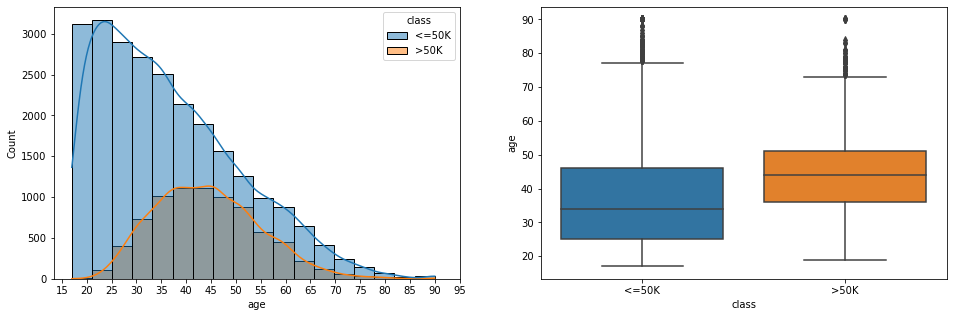

In [31]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'age'

sns.histplot(x=col, kde=True, hue='class', data=df_eda, bins=18, ax=ax[0]);
sns.boxplot(x="class", y=col, data=df_eda, ax=ax[1]);

xticks = list(range(15,100,5))
ax[0].set_xticks(xticks);
ax[0].set_xticklabels(xticks);

Young people are more likely to earn less than 50k/year.

#### 5.1.4 education_num

H2: The more education, the higher is the salary. [True]

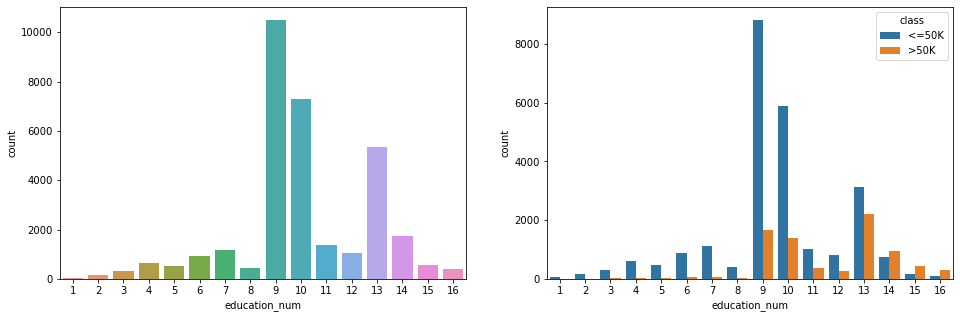

In [32]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'education_num'

sns.countplot(x=col, data=df_eda, ax=ax[0])
sns.countplot(x=col, hue='class', data=df_eda, ax=ax[1]);

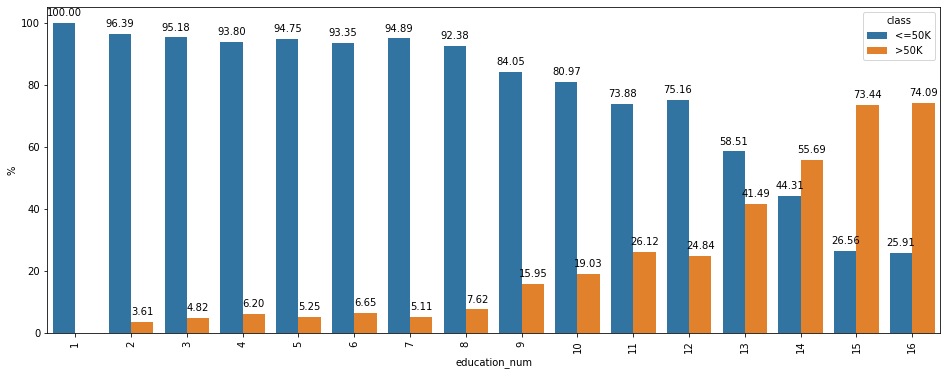

In [33]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'education_num'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xticks(rotation=90);

Note how the chance picking a person that earns >50k/year grows with education_num.<br>
After, 13, the chance of earning >50k/year is greater than the chance of earning <50k/year.

#### 5.1.5 capital_gain

H3: The higher is the capital gain, the higher is the probability of having a salary that is greater than 50k/year. [True]

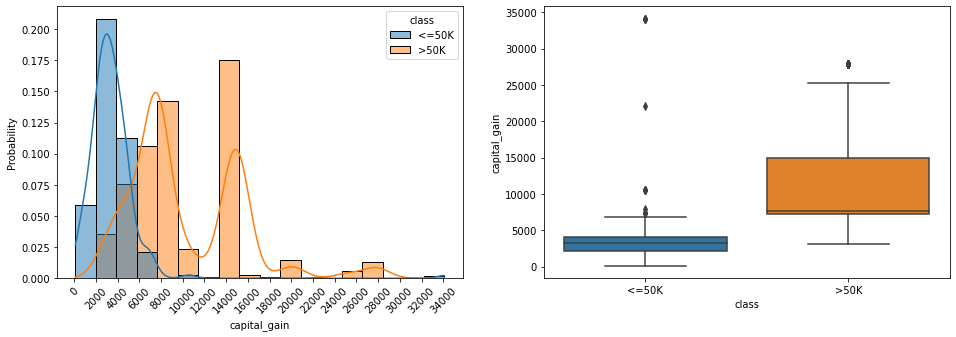

In [34]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'capital_gain'

sns.histplot(x=col, kde=True, hue='class', stat='probability', data=df_eda[(0 < df_eda['capital_gain']) & (df_eda['capital_gain'] < 40000)], bins=18, ax=ax[0]);
sns.boxplot(x="class", y=col, data=df_eda[(0 < df_eda['capital_gain']) & (df_eda['capital_gain'] < 40000)], ax=ax[1]);

xticks = list(range(0,35000,2000))
ax[0].set_xticks(xticks);
ax[0].set_xticklabels(xticks, rotation=45);

capital_gain seems to be an important feature to help prediction if a person earns more than 50k/year.

#### 5.1.6 capital_loss

H4: The higher is the capital loss, the lower is the probability of having a salary that is greater than 50k/year. [False]

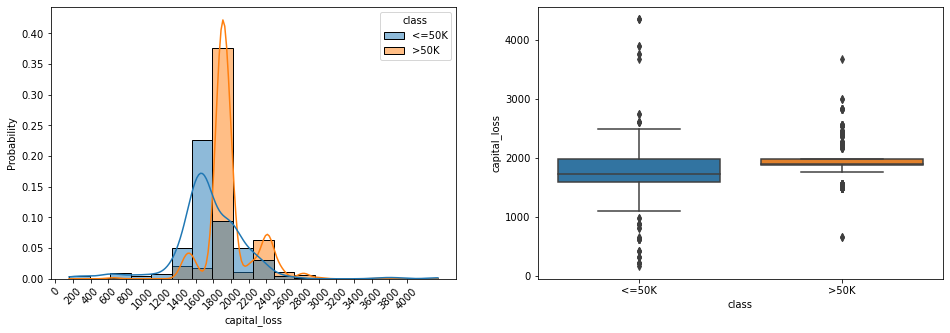

In [35]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'capital_loss'

sns.histplot(x=col,  kde=True, hue='class', stat='probability', data=df_eda[(0 < df_eda[col])], bins=18, ax=ax[0]);
sns.boxplot(x="class", y=col, data=df_eda[(0 < df_eda[col])], ax=ax[1]);

xticks = list(range(0,4200,200))
ax[0].set_xticks(xticks);
ax[0].set_xticklabels(xticks, rotation=45);

The person has a higher chance of wins more than 50k/year if he has a capital_loss between 1800 and 2000 anually.

#### 5.1.7 hours_per_week

H5: The more a person work per week, the higher is the probability of having a salary that is greater than 50k/year. [False]

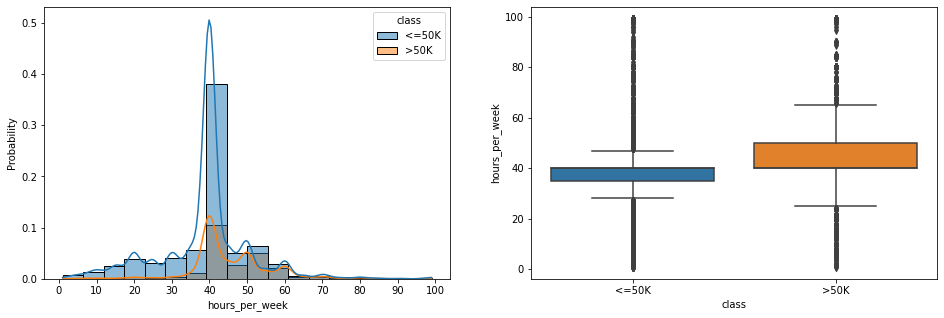

In [36]:
fig, ax = plt.subplots(1,2,figsize=(16,5))

col = 'hours_per_week'

sns.histplot(x=col, stat='probability', kde=True, hue='class', data=df_eda[(0 < df_eda[col])], bins=18, ax=ax[0]);
sns.boxplot(x="class", y=col, data=df_eda[(0 < df_eda[col])], ax=ax[1]);

ax[0].set_xticks(list(range(0,110,10)));

The distributions are overlapping (>50k and <=50k), but hours_per_week can be useful together with other features.
Even though, we can say the median of weekly working hours of people that earn more than 50k/year is greater than the median of others.

#### 5.1.8 Overall numeric features correlation

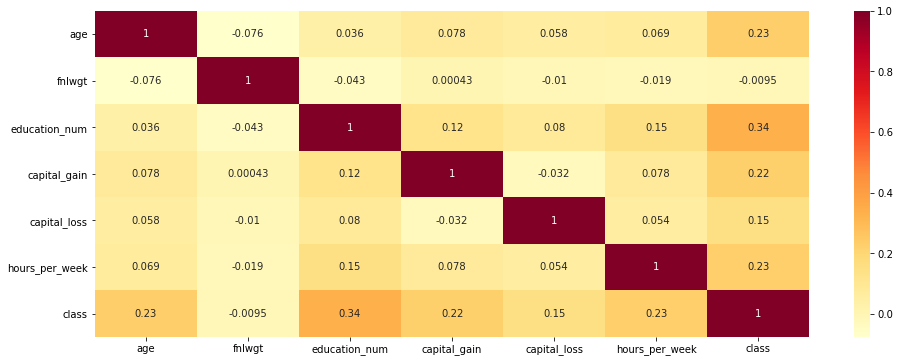

In [37]:
fig, ax = plt.subplots(figsize=(16,6))
di = {'<=50K':-1, '>50K': 1}
corr = df_eda.replace({"class": di}).corr('pearson')
sns.heatmap(corr, annot=True, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap='YlOrRd');

education_num has the highest correlation to the class. <br>
Almost every feature has a positive correlation to the class, except fnlwgt which has almost zero correlation to the class, therefore it has low impact in class prediction by itself.

### 5.2 Categorical Features

#### 5.2.1 Data Description

In [38]:
df_eda.describe(include='object')

,workclass,education,marital_status,occupation,relationship,race,sex,native_country,class,worktype,living_with_spouse,native_region,country-type,married
count,32537,32537,32537,32537,32537,32537,32537,32537,32537,32537,32537,32537,32537,32537
unique,9,16,7,16,6,5,2,42,2,5,2,5,3,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K,private,no,North America,developed-country,no
freq,22673,10494,14970,4136,13187,27795,21775,29153,24698,22673,17544,30565,30026,17782


All categorical features seems to make sense in terms of unique values that are not too high. <br>
The freq is very high (85%+) for a bunch of features country-type, native_region, native_country and race. This means, for each feature, there's a category that dominates. 

#### 5.2.2 workclass

H6: The people who work for private companies have a higher probability of having a salary of 50k/year. [False]

H7: The people who never work or work without payment, a higher probability of having a salary of less than 50k/year. [True]

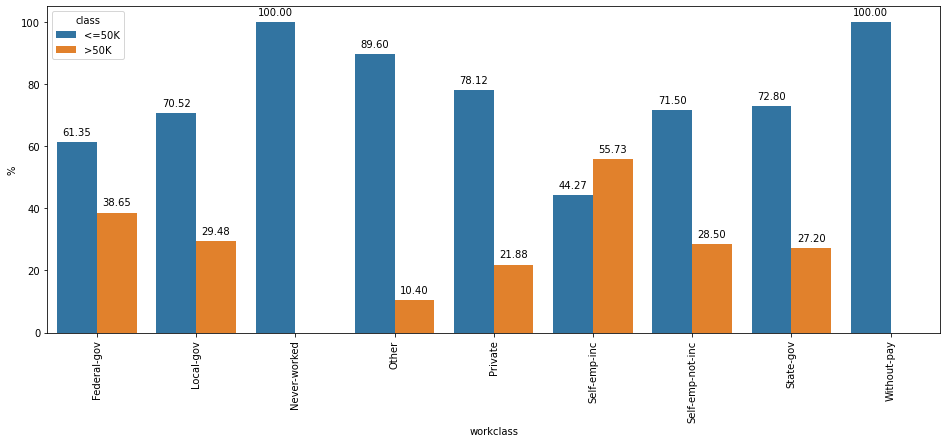

In [39]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'workclass'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux.sort_values('class'));

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xticks(rotation=90);

Tree highlights here:<br> (1) Never-worked and Without-pay earns <=50k/year;<br> (2) Other are very likely to earn <=50k/year;<br> (3) Self-emp-inc is the unique category in which the majority earn >50k/year

OBS: Incorporated self employment: Refers to people who work for themselves in corporate entities. Unincorporated self employment: Refers to people who work for themselves in other legal entities.

#### 5.2.3 worktype

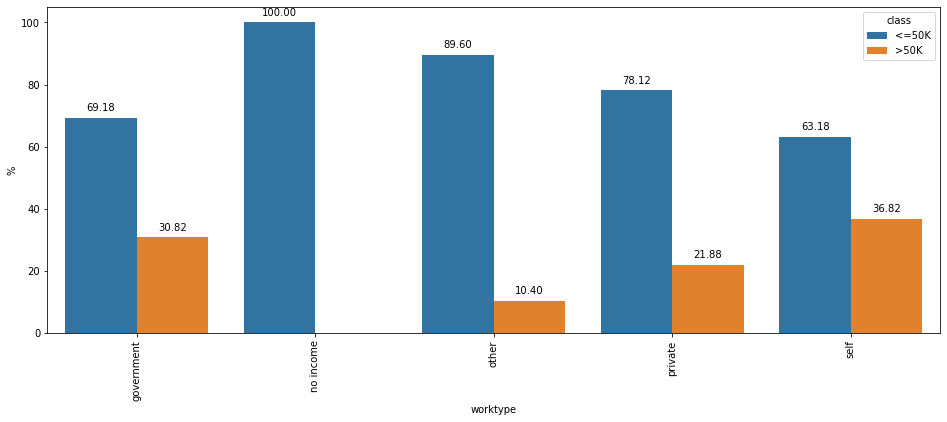

In [40]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'worktype'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux.sort_values('class'));

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xticks(rotation=90);

People who work for theirselves are more likely to earn more than 50k/year, followed by people who work for government and private companies, respectively.

#### 5.2.4 education

**H8**: The higher the academic training, the higher is the probability of having a salary of 50k/year. [True]

In [41]:
cols_order = [v for _,v in sorted(list(set([tuple(i) for i in list(df_eda[['education_num', 'education']].values)])), key=lambda x:x[0])]

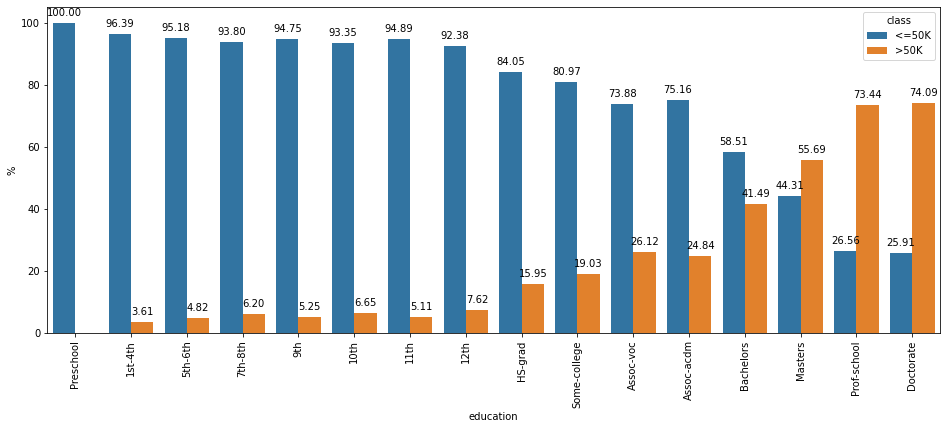

In [42]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'education'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux, order=cols_order);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xticks(rotation=90);

Already discussed, the higher is the academic formation , the higher is the chance of earn more than 50k/year;
In the feature selection, we can chose between education and education_num. In this case, keeping education_num seems to be a better choice because it has a better representation for an ordinal feature.

#### 5.2.5 marital_status

**H9**: People living with family have a higher probability of having a salary of 50k/year. [True]

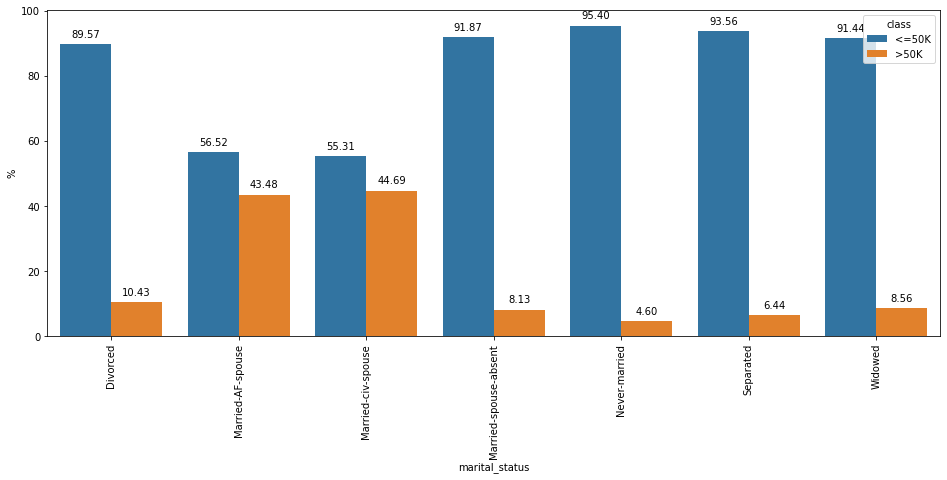

In [43]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'marital_status'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

plt.xticks(rotation=90);

People who live with their partners are more likely to earn a salary greater than 50k a year. 

#### 5.2.6 living_with_spouse

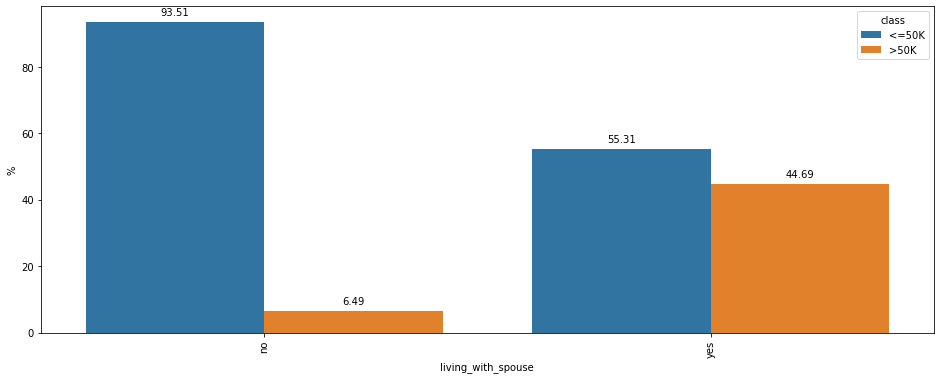

In [44]:
fig, ax = plt.subplots(figsize=(16,6))

col = 'living_with_spouse'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

The conclusion above are more clear here.

#### 5.2.7 occupation

**H10**: The people with no occupation, a higher probability of having a salary of less than 50k/year. [True]

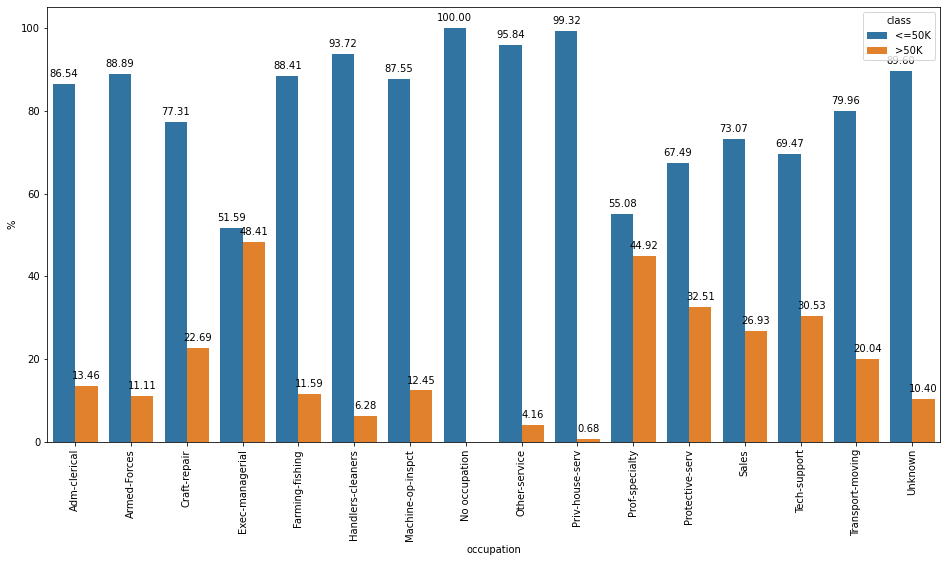

In [45]:
fig, ax = plt.subplots(figsize=(16,8))

col = 'occupation'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

Similar to workclass, no occupation has no chance of earn a salary greater than 50k/year.

#### 5.2.8 relationship

**H9**: Married people have a higher probability of having a salary of 50k/year. [True]

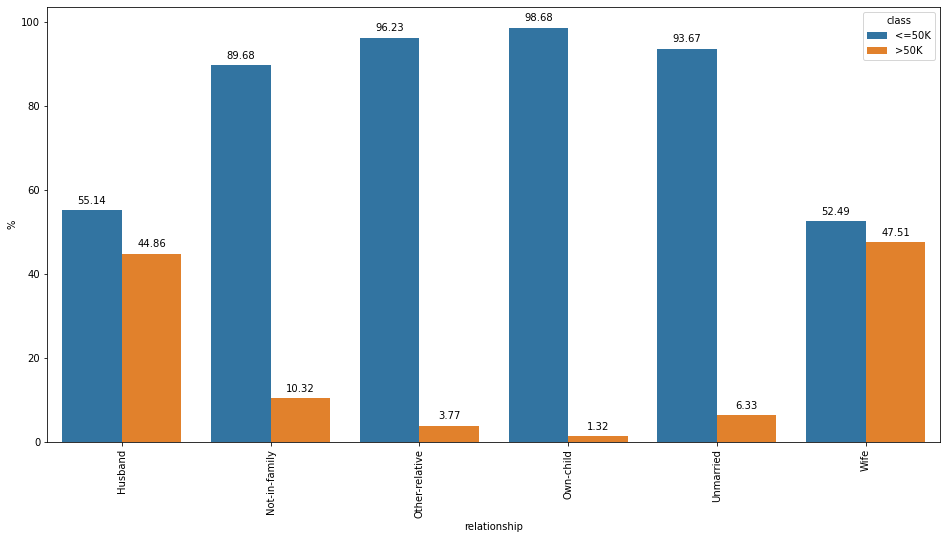

In [46]:
fig, ax = plt.subplots(figsize=(16,8))

col = 'relationship'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

Married people living with spouse have a higher chance of earn >50k/year.

#### 5.2.8.1 married

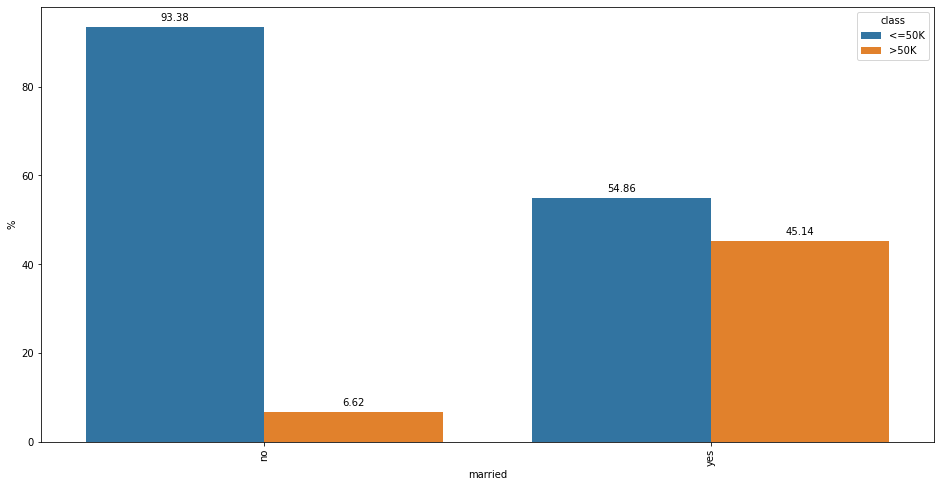

In [47]:
fig, ax = plt.subplots(figsize=(16,8))

col = 'married'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

Even more clear with this visualization.

#### 5.2.9 race

**H9**: White people have are more likely to earn more than 50k annually. [False, White people have a high probability but not higher than the Asians have.]

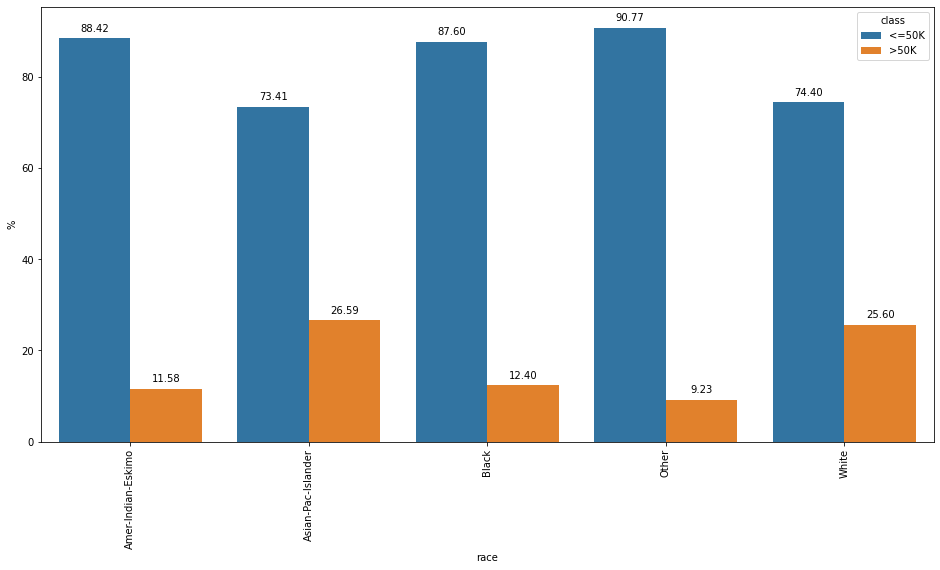

In [48]:
fig, ax = plt.subplots(figsize=(16,8))

col = 'race'
data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

#### 5.2.10 sex

**H10**: Men have are more likely to earn more than 50k annually. [True]

In [49]:
col = 'sex'

In [50]:
cols_order = df_train[col].value_counts(normalize=False).sort_values(ascending=False).head(10).keys()

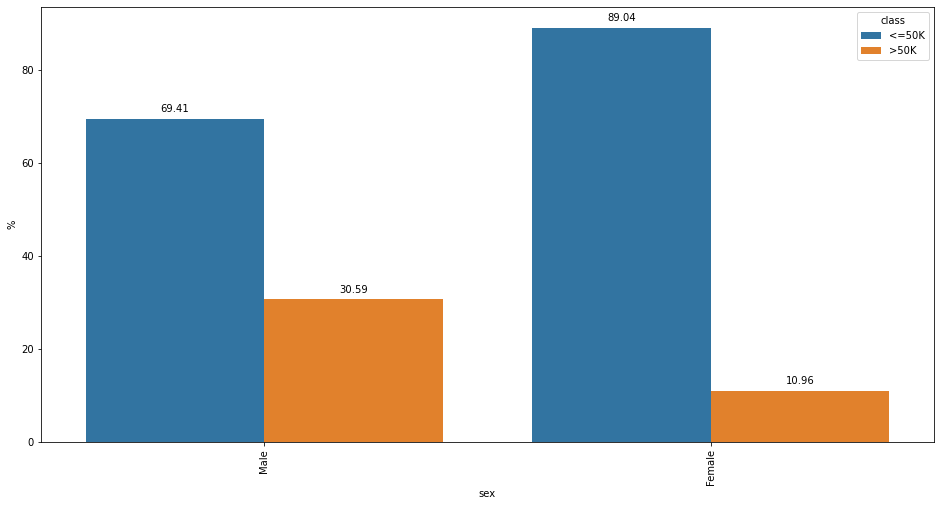

In [51]:
fig, ax = plt.subplots(figsize=(16,8))

data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux, order=cols_order);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

Men have higher chance of earn >50k/year.

#### 5.2.11 native_country

**H11**: People from First World countries . [True]

In [52]:
col = 'native_country'

In [53]:
cols_order = df_eda[col].value_counts(normalize=False).sort_values(ascending=False).head(10).keys()

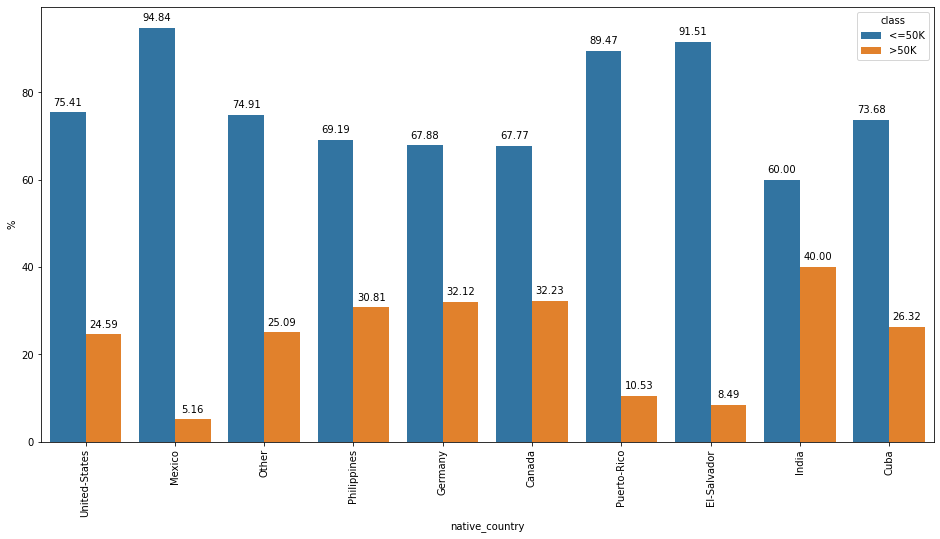

In [54]:
fig, ax = plt.subplots(figsize=(16,8))

data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()#.head(10)
sns.barplot(x=col, y='%', hue='class', data=data_aux, order = cols_order);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

#### 5.2.12 native_region

In [55]:
col = 'native_region'

In [56]:
cols_order = df_eda[col].value_counts(normalize=False).sort_values(ascending=False).head(10).keys()

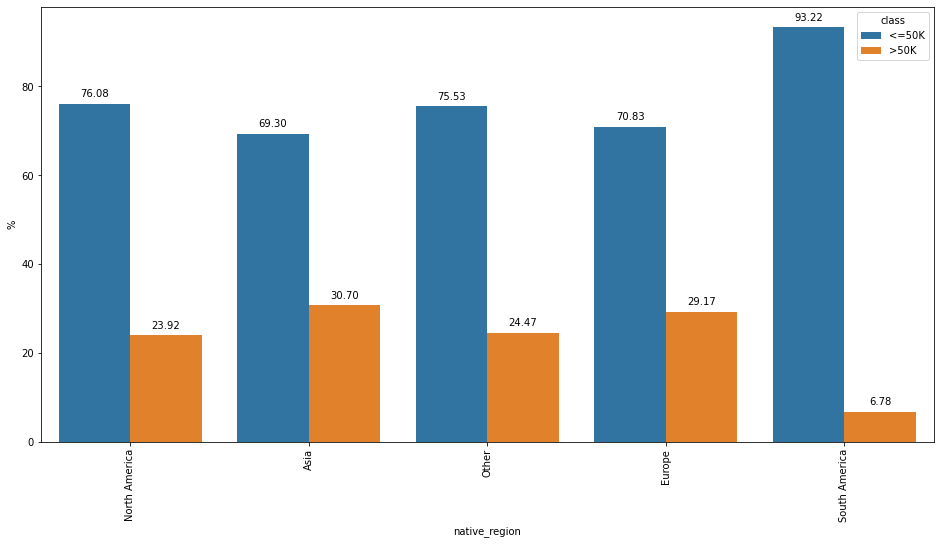

In [57]:
fig, ax = plt.subplots(figsize=(16,8))

data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux, order=cols_order);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=90);

People that are native from South America are more likely to earn <=50k/year. <br>
Other category doesn't seems like "others", because it represents the third largest volume of the data.

#### 5.2.13 country-type

In [58]:
col = 'country-type'

In [59]:
cols_order = df_eda[col].value_counts(normalize=False).sort_values(ascending=False).head(10).keys()

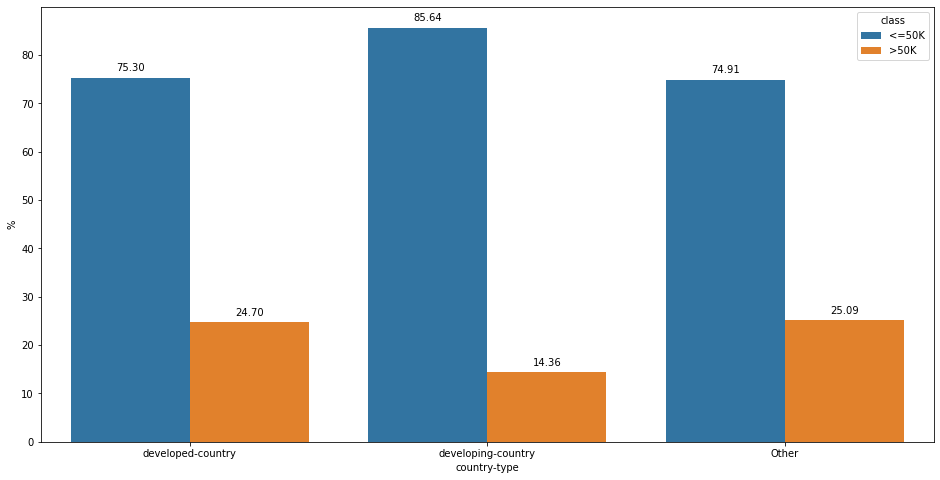

In [60]:
fig, ax = plt.subplots(figsize=(16,8))

data_aux = df_eda.groupby(col)['class'].value_counts(normalize=True).mul(100).rename('%').reset_index()
sns.barplot(x=col, y='%', hue='class', data=data_aux, order=cols_order);

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
       ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')


plt.xticks(rotation=0);

Numbers of developed-country vs developing-country make sense, but "Other" seems to be hindering the analysis. We should be able to know where each people are from.

#### 4.2.10 Overall categorical features correlation

In [61]:
d_cramers = dict()

df_eda_cat = df_eda.select_dtypes(exclude=['int64', 'float64'])

for col in list(df_eda_cat.columns):
    d_cramers[col] = []
    for col_2 in list(df_eda_cat.columns):
        d_cramers[col].append(round(cramers_V(df_eda[col], df_eda[col_2]),2))

df = pd.DataFrame(d_cramers)
df.set_index(df.columns);

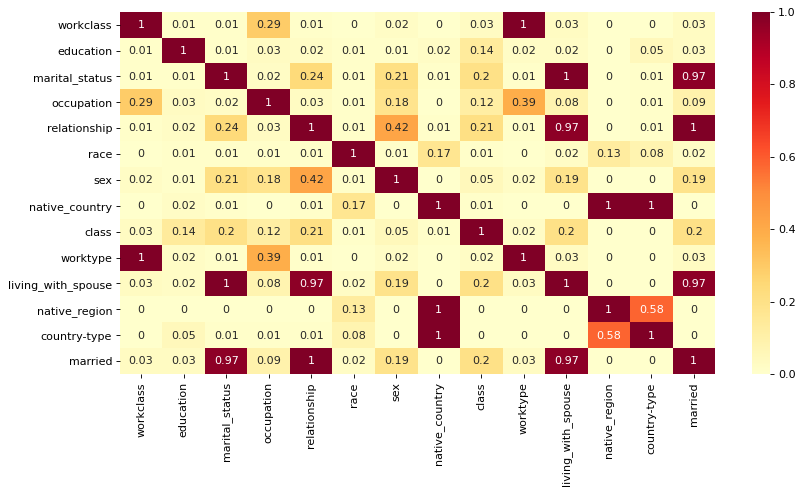

In [62]:
plt.figure(figsize=(12, 6), dpi=80);
sns.heatmap(df, annot=True, xticklabels=df.columns.values, yticklabels=df.columns.values, cmap='YlOrRd');

relationship is the feature with the greatest correlation to the class.
Several features interact with each other and we should be able to choose which one we want to use.
In the next step we will select only a subset of these features.

# 5.0 Feature Selection

In [63]:
df_fs = df_eda.copy()

### 5.1 Manual Feature Selection

1) There is no point in using **education** and **education num** as they represent the same information. Therefore, will keep education_num as it is in a better format for an ordinal feature.<br>
2) **worktype** and **workclass** represents the same information, but workclass have a higher correlation to the class.<br>
3) **living_with_spouse** and **marital_status** represents the same information, but **living_with_spouse** is simpler.<br>
4) **country-type** and **native-region** represents the same information and have a lower correlation than **native-country**.<br>
5) **relationship** and **living_with_spouse** nearly represent the same information, but **living_with_spouse** is simpler.

In [64]:
selected_cols = set(['age', 'fnlwgt', 'workclass', 'occupation', 'education_num', 'living_with_spouse', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country'])

### 5.2 Boruta as a Feature Selection

In [95]:
cols_before = df_fs.apply(LabelEncoder().fit_transform).drop(columns=['class']).columns
X = df_fs.apply(LabelEncoder().fit_transform).drop(columns=['class'])
y = [0 if c == '<=50K' else 1 for c in df_fs['class'].values]

In [97]:
rf = XGBClassifier(eval_metric='aucpr', use_label_encoder=False)
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=1)
boruta.fit(X.values, y);

#### 5.2.1 Features selected by Boruta

In [67]:
selected_boruta = set(cols_before[boruta.support_])
selected_boruta

{'age',
 'capital_gain',
 'capital_loss',
 'country-type',
 'education_num',
 'hours_per_week',
 'living_with_spouse',
 'marital_status',
 'married',
 'native_region',
 'occupation',
 'relationship',
 'sex',
 'workclass'}

#### 5.2.2 Features discarded by Boruta

In [68]:
set(cols_before)-(set(cols_before[boruta.support_]).union(set(cols_before[boruta.support_weak_])))

{'education', 'fnlwgt', 'native_country', 'worktype'}

#### 5.2.3 Features with inconclusive results

In [69]:
set(cols_before[boruta.support_weak_])

{'race'}

#### 5.2.4 Diferences between Selected Features

In [70]:
selected_boruta-selected_cols

{'country-type', 'marital_status', 'married', 'native_region'}

In [71]:
selected_cols-selected_boruta

{'fnlwgt', 'native_country', 'race'}

### 5.3 Feature Importance with XGBoost and Shap Values

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


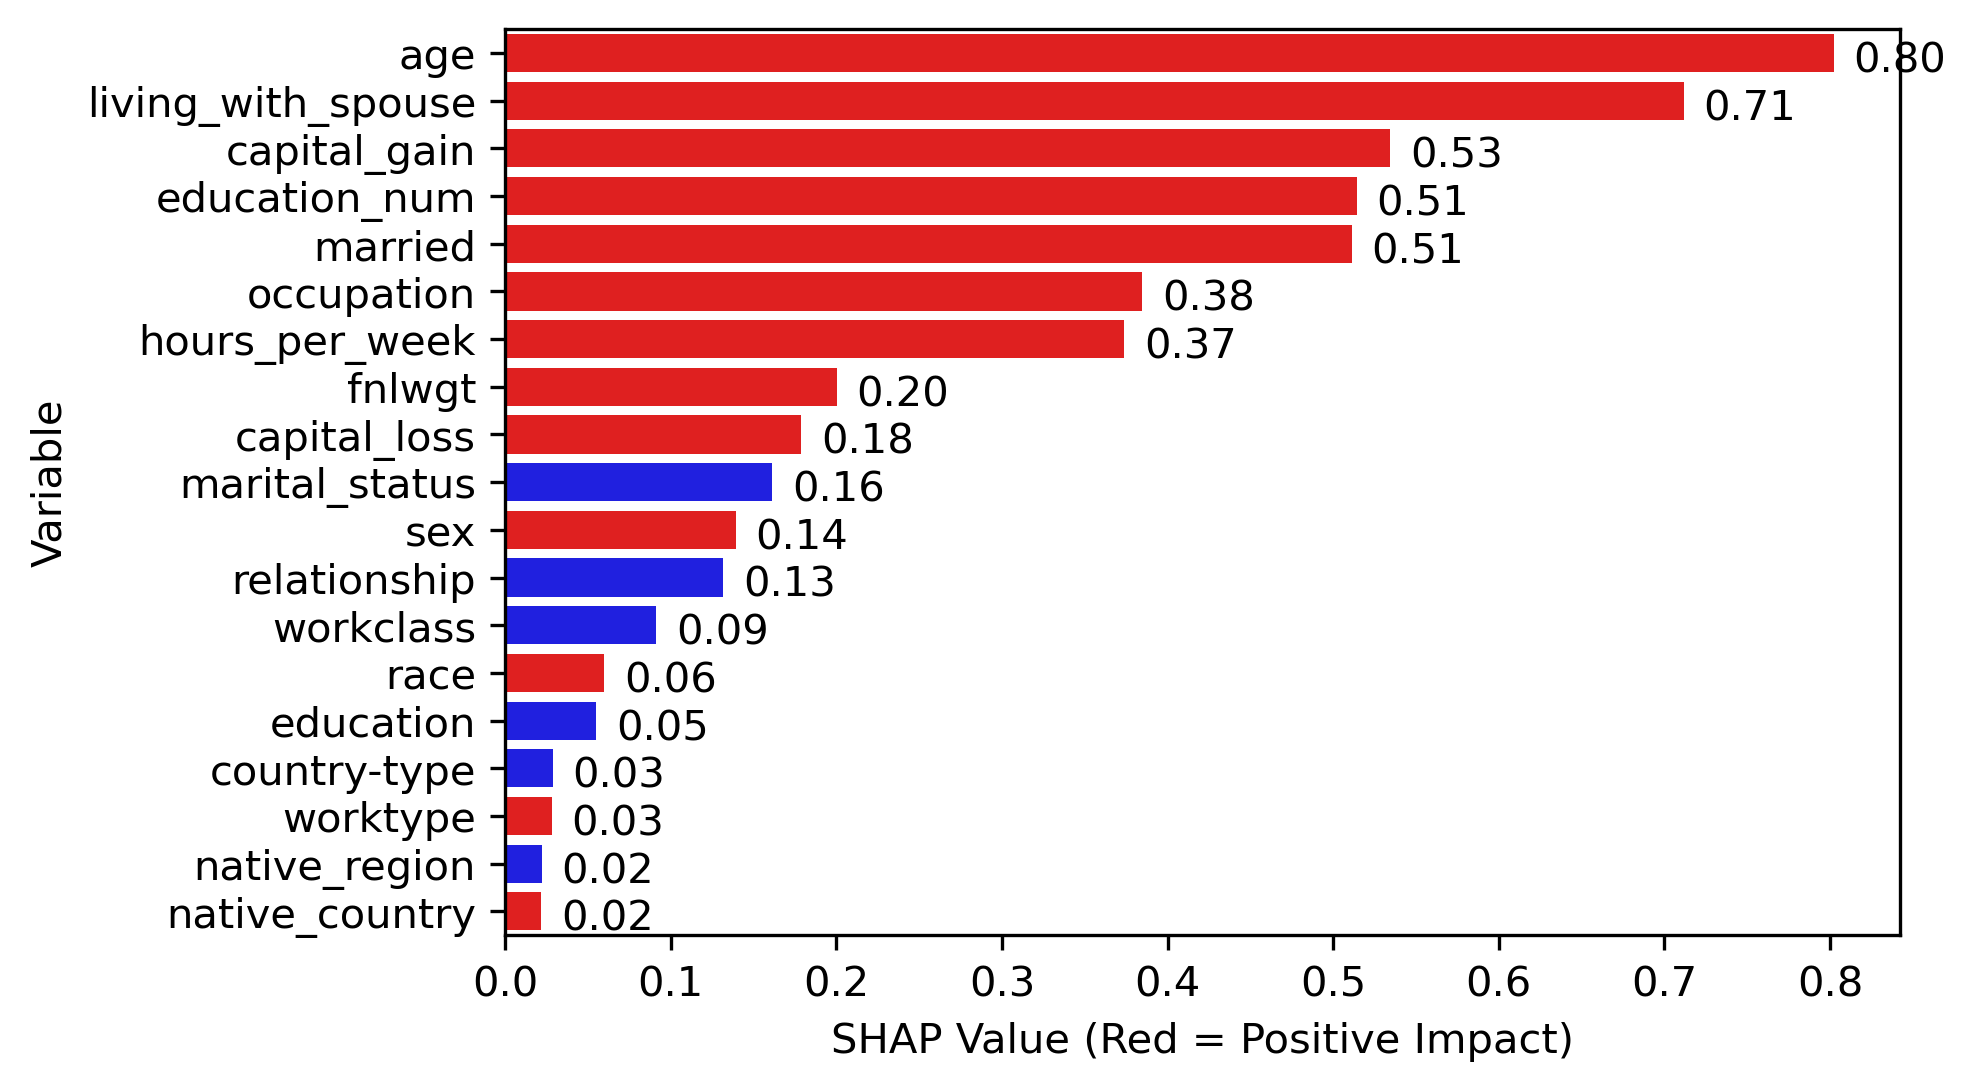

In [72]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

model = XGBClassifier(eval_metric='aucpr', use_label_encoder=False).fit(X,y)
shap_values = shap.TreeExplainer(model).shap_values(X)
k2 = plot_simplified_shap(shap_values, X)

ax = sns.barplot(y='Variable', x='SHAP_abs', data=k2, palette=k2['Sign'])

for p in ax.patches:
    width = p.get_width()
    plt.text(0.04+p.get_width(), p.get_y()+0.7*p.get_height(),
             '{:1.2f}'.format(width), ha='center', va='center')
    
plt.xlabel('SHAP Value (Red = Positive Impact)');

### 5.4 Feature Selection - Final Decision

It seems there is no much difference between the sets of selected features. However, I'll substitute native_country by native_region and add country-type, marital_status and married to the selected features.

In [73]:
selected_cols = set(['age', 'fnlwgt', 'workclass', 'occupation', 'education_num', 'living_with_spouse', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'country-type', 'marital_status', 'married', 'native_region'])

# 6.0 Machine Learning Models and Hyperparameter Optimization

### 6.1 Preparing the training data

In [74]:
X_train = df_fs[selected_cols]
y_train = [-1 if c == '<=50K' else 1 for c in df_fs['class'].values]

In [75]:
cat = X_train.select_dtypes(include=['object']).columns
num = X_train.select_dtypes(include=['int64', 'float64']).columns

### 6.2 Defining the pipeline

In [76]:
cat_pipe = Pipeline(steps=[('Imputation', SimpleImputer(strategy='constant', fill_value='other')),
                           ('CatEncoding', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

dc_pipe = [('numerical_preprocessing', StandardScaler(), num), ('categorical_preprocessing', cat_pipe, cat)]

preprocessor = ColumnTransformer(transformers=dc_pipe)
final_pipeline = Pipeline(steps=[('preprocessing', preprocessor), ('classifier', None)])

### 6.3 Hyperparameter Tuning and Model Selecting

In [77]:
param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__C': [0.001, 0.1, 1, 100]},
    
    {'classifier': [Ridge()],
     'classifier__alpha': [0.001, 0.1, 1, 100]},
    
    {'classifier': [Lasso()],
     'classifier__alpha': [0.001, 0.1, 1, 100]},
    
    {'classifier': [KNeighborsClassifier()],
     'classifier__n_neighbors': [1, 5, 7, 11, 13]},
    
    {'classifier': [DecisionTreeClassifier()],
    'classifier__criterion' : ['gini', 'entropy'],
    'classifier__max_depth' : [2, 4, 6, 8, 10],
    'classifier__min_samples_split' : [2, 4 , 6 , 8 ,10],
    'classifier__min_samples_leaf' : [2, 4, 6, 8, 10], 
    'classifier__splitter' : ['best', 'random'],
    'classifier__max_features' : ['auto', 'log2', None]},

    {'classifier': [RandomForestClassifier()],
    'classifier__n_estimators': [100, 400, 700, 1000],
    'classifier__max_depth': [2, 4, 6, 8, 10],
    'classifier__min_samples_split' : [2, 4 , 6 , 8 ,10],
    'classifier__min_samples_leaf' : [2, 4, 6, 8, 10], 
    'classifier__max_features': ['auto', 'log2', None]},
    
    {'classifier': [XGBClassifier()],
    'classifier__n_estimators': [100, 400, 700, 1000],
    'classifier__max_depth': [2, 4, 6, 8, 10]},
    
    {'classifier': [LGBMClassifier()],
    'classifier__n_estimators': [100, 400, 700, 1000],
    'classifier__max_depth': [2, 4, 6, 8, 10]}
]

#grid = GridSearchCV(final_pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring='roc_auc')
#grid.fit(X_train, y_train)

grid = RandomizedSearchCV(final_pipeline, param_distributions=param_grid, cv=5, n_jobs=4, scoring='roc_auc')
grid.fit(X_train, y_train)

print("Random-Search")
print("Best parameters:", grid.best_params_)
print("Best cross-validation score): {:.3f}".format(grid.best_score_))

Random-Search
Best parameters: {'classifier__n_estimators': 1000, 'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 10, 'classifier__max_features': None, 'classifier__max_depth': 10, 'classifier': RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=1000)}
Best cross-validation score): 0.916


In [78]:
print(classification_report(y_train, grid.predict(X_train)))

              precision    recall  f1-score   support

          -1       0.88      0.96      0.92     24698
           1       0.81      0.59      0.68      7839

    accuracy                           0.87     32537
   macro avg       0.85      0.77      0.80     32537
weighted avg       0.86      0.87      0.86     32537



### 6.4 Application of the best model in test dataset

#### 6.4.1 Load the test data

In [82]:
df_test = pd.read_csv('data\\adult.test', skiprows=1, header=None, skipinitialspace=True, na_values='?')

cols = ['age', 'workclass', 'fnlwgt', 'education', 'education_num', 'marital_status', 'occupation',
        'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'class']

df_test.columns = cols

#### 6.4.2 Apply feature engineering

In [85]:
di = {'Private': 'private',
      'Local-gov':'government',
      'State-gov':'government',
      'Self-emp-not-inc':'self',
      'Self-emp-inc': 'self',
      'Federal-gov':'government',
      'Without-pay':'no income',
      'Never-worked':'no income',
      'Other': 'other'}

df_test['worktype'] = df_test['workclass'].map(di)

di = {'Married-civ-spouse': 'yes', 'Never-married': 'no', 'Divorced':'no', 'Separated': 'no',
      'Widowed':'no', 'Married-spouse-absent': 'no', 'Married-AF-spouse':'yes'}

df_test['living_with_spouse'] = df_test['marital_status'].map(di)

di = {'Canada':'North America','Cuba':'North America','Dominican-Republic':'North America','El-Salvador':'North America','Guatemala':'North America','Haiti':'North America','Honduras':'North America','Jamaica':'North America','Mexico':'North America','Nicaragua':'North America','Outlying-US(Guam-USVI-etc)':'North America','Puerto-Rico':'North America','Trinadad&Tobago':'North America','United-States':'North America','Cambodia':'Asia','China':'Asia','Hong':'Asia','India':'Asia','Iran':'Asia','Japan':'Asia','Laos':'Asia','Philippines':'Asia','Taiwan':'Asia','Thailand':'Asia','Vietnam':'Asia','Columbia':'South America','Ecuador':'South America','Peru':'South America','England':'Europe','France':'Europe','Germany':'Europe','Greece':'Europe','Holand-Netherlands':'Europe','Hungary':'Europe','Ireland':'Europe','Italy':'Europe','Poland':'Europe','Portugal':'Europe','Scotland':'Europe','Yugoslavia':'Europe','South':'Other','Other':'Other'}

df_test['native_region'] = df_test['native_country'].map(di)

di = {'Canada':'developed-country', 'Cuba':'developing-country', 'Dominican-Republic':'developing-country', 'El-Salvador':'developing-country', 'Guatemala':'developing-country', 'Haiti':'developing-country', 'Honduras':'developing-country', 'Jamaica':'developing-country', 'Mexico':'developing-country', 'Nicaragua':'developing-country', 'Outlying-US(Guam-USVI-etc)':'developing-country', 'Puerto-Rico':'developed-country', 'Trinadad&Tobago':'developing-country', 'United-States':'developed-country', 'Cambodia':'developing-country', 'China':'developing-country', 'Hong':'developed-country', 'India':'developing-country', 'Iran':'developing-country', 'Japan':'developed-country', 'Laos':'developing-country', 'Philippines':'developing-country', 'Taiwan':'developed-country', 'Thailand':'developing-country', 'Vietnam':'developing-country', 'Columbia':'developing-country', 'Ecuador':'developing-country', 'Peru':'developing-country', 'England':'developed-country', 'France':'developed-country', 'Germany':'developed-country', 'Greece':'developed-country', 'Holand-Netherlands':'developed-country', 'Hungary':'developed-country', 'Ireland':'developed-country', 'Italy':'developed-country', 'Poland':'developed-country', 'Portugal':'developed-country', 'Scotland':'developed-country', 'Yugoslavia':'developing-country', 'South':'developing-country', 'Other':'Other'}

df_test['country-type'] = df_test['native_country'].map(di)

di = {'Not-in-family':'no', 'Husband':'yes', 'Wife':'yes', 'Own-child':'no', 'Unmarried':'no',
       'Other-relative':'no'}

df_test['married'] = df_test['relationship'].map(di)

#### 6.4.3 Preparing test data

In [86]:
X_test = df_test[selected_cols]
y_test = [-1 if c == '<=50K.' else 1 for c in df_test['class'].values]

#### 6.4.4 Apply the preprocessing step

In [92]:
pre = preprocessor.fit(X_train)
model = RandomForestClassifier(max_depth=10, max_features=None, min_samples_leaf=10,
                       min_samples_split=10, n_estimators=1000).fit(pre.transform(X_train), y_train)

In [93]:
X_test_pp = pre.transform(X_test)

#### 6.4.5 Apply the model and report the resuts

In [94]:
print(classification_report(y_test, model.predict(X_test_pp)))

              precision    recall  f1-score   support

          -1       0.88      0.95      0.91     12435
           1       0.79      0.57      0.66      3846

    accuracy                           0.86     16281
   macro avg       0.83      0.76      0.79     16281
weighted avg       0.86      0.86      0.85     16281

